<a href="https://colab.research.google.com/github/Ajay-user/ML-DL-RL-repo/blob/master/%20Structured%20data%20/Modeling_structured_data_using_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Resource:
# https://www.tensorflow.org/tutorials/load_data/pandas_dataframe#read_data_using_pandas

In [1]:
import pandas as pd
import tensorflow as tf

## Load the Data

In [2]:
csv_file = tf.keras.utils.get_file('heart.csv', 'https://storage.googleapis.com/download.tensorflow.org/data/heart.csv')

24576/13273 [=======================================================] - 0s 0us/step


In [8]:
heart_df = pd.read_csv(csv_file)
heart_df.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [ ]:
# check for null values
heart_df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [ ]:
# feature types 
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 33.3+ KB


## Feature and target

In [9]:
# Feature and target
y = heart_df.pop('target')
X = heart_df

In [10]:
numeric_feature_names = ['age', 'thalach', 'trestbps',  'chol', 'oldpeak']
binary_feature_names = ['sex', 'fbs', 'exang']
categorical_feature_names = ['cp', 'restecg', 'slope', 'thal', 'ca']

## Utility Functions

In [5]:
def stack_dict(inputs, fn=tf.stack):
  vals=[]
  for key in sorted(inputs.keys()):
    vals.append(tf.cast(inputs[key], tf.float32))
  return fn(vals, axis=-1)

## Model building 

### Baseline

#### Sequential API

In [ ]:
## Baseline model using Sequential API

features = X[numeric_feature_names]

# converting features into tensors 
feat_tensor = tf.convert_to_tensor(features)

# baseline model
baseline = tf.keras.Sequential([
                                tf.keras.layers.Dense(32,'relu'),
                                tf.keras.layers.Dense(1),

])
# compile 
baseline.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
# training
baseline.fit(feat_tensor, y, epochs=5)

Epoch 1/5
10/10 [==============================] - 1s 2ms/step - loss: 3.6844 - accuracy: 0.6964
Epoch 2/5
10/10 [==============================] - 0s 2ms/step - loss: 2.7428 - accuracy: 0.6007
Epoch 3/5
10/10 [==============================] - 0s 2ms/step - loss: 2.4650 - accuracy: 0.7129
Epoch 4/5
10/10 [==============================] - 0s 2ms/step - loss: 1.9415 - accuracy: 0.6964
Epoch 5/5
10/10 [==============================] - 0s 2ms/step - loss: 1.8405 - accuracy: 0.6931


In [ ]:
# if we look at the mean and std of the numerical features its bouncing around
features .describe().T.loc[:,['mean','std']]

,mean,std
age,54.594059,9.016370
thalach,149.194719,23.173368
trestbps,131.785479,17.748338
chol,246.547855,52.175933
oldpeak,1.057756,1.165025


In [ ]:
# let's add a normalizing layer to the baseline model
normalize = tf.keras.layers.Normalization()
normalize.adapt(features)

baseline_normalized = tf.keras.Sequential([
                                           normalize,
                                           tf.keras.layers.Dense(32,'relu'),
                                           tf.keras.layers.Dense(1),
])
# compile
baseline_normalized.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
baseline_normalized.fit(feat_tensor, y, epochs=5)

Epoch 1/5
10/10 [==============================] - 0s 2ms/step - loss: 0.8665 - accuracy: 0.4818
Epoch 2/5
10/10 [==============================] - 0s 2ms/step - loss: 0.8118 - accuracy: 0.5479
Epoch 3/5
10/10 [==============================] - 0s 2ms/step - loss: 0.7623 - accuracy: 0.6370
Epoch 4/5
10/10 [==============================] - 0s 2ms/step - loss: 0.7186 - accuracy: 0.7162
Epoch 5/5
10/10 [==============================] - 0s 2ms/step - loss: 0.6806 - accuracy: 0.7360


#### Model-subclassing

In [ ]:
#  The Model-subclass style

class MyBaselineModel(tf.keras.Model):
  def __init__(self):
    super(MyBaselineModel,self).__init__()
    self.normalize = tf.keras.layers.Normalization()
    self.dense = tf.keras.layers.Dense(32, 'relu')
    self.output_layer = tf.keras.layers.Dense(1)

  def adapt(self,inputs):
    inputs = stack_dict(inputs)
    self.normalize.adapt(inputs)
  
  def call(self, x):
    x = stack_dict(x)
    x = self.normalize(x)
    x = self.dense(x)
    x = self.output_layer(x)
    return x

In [ ]:
# initialize an instance of the class MyBaselineModel
my_base = MyBaselineModel()
# adapt the normalizer
my_base.adapt(dict(features))
# compile the model
my_base.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
# train the model
my_base.fit(dict(features), y, epochs=5)

Epoch 1/5
10/10 [==============================] - 1s 2ms/step - loss: 0.6668 - accuracy: 0.7525
Epoch 2/5
10/10 [==============================] - 0s 2ms/step - loss: 0.6320 - accuracy: 0.7624
Epoch 3/5
10/10 [==============================] - 0s 2ms/step - loss: 0.6036 - accuracy: 0.7690
Epoch 4/5
10/10 [==============================] - 0s 2ms/step - loss: 0.5787 - accuracy: 0.7657
Epoch 5/5
10/10 [==============================] - 0s 2ms/step - loss: 0.5592 - accuracy: 0.7624


#### Keras functional API

In [ ]:
# The Keras functional style

inputs = {}
for col in features.columns:
  inputs[col] = tf.keras.Input(shape=(1,), name=col, dtype=tf.float32)

inputs

{'age': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age')>,
 'chol': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'chol')>,
 'oldpeak': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'oldpeak')>,
 'thalach': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'thalach')>,
 'trestbps': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'trestbps')>}

In [ ]:
# lets concatenate the inputs 
concated_inputs = stack_dict(inputs, fn=tf.concat)
concated_inputs

<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'tf.concat_1')>

In [ ]:
# normalization
normalize = tf.keras.layers.Normalization()
normalize.adapt(stack_dict(dict(features)))

x = normalize(concated_inputs)
x = tf.keras.layers.Dense(32, 'relu')(x)
results = tf.keras.layers.Dense(1)(x)

my_base_model = tf.keras.Model(inputs, results)

my_base_model.compile(optimizer='adam',
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics=['accuracy'])

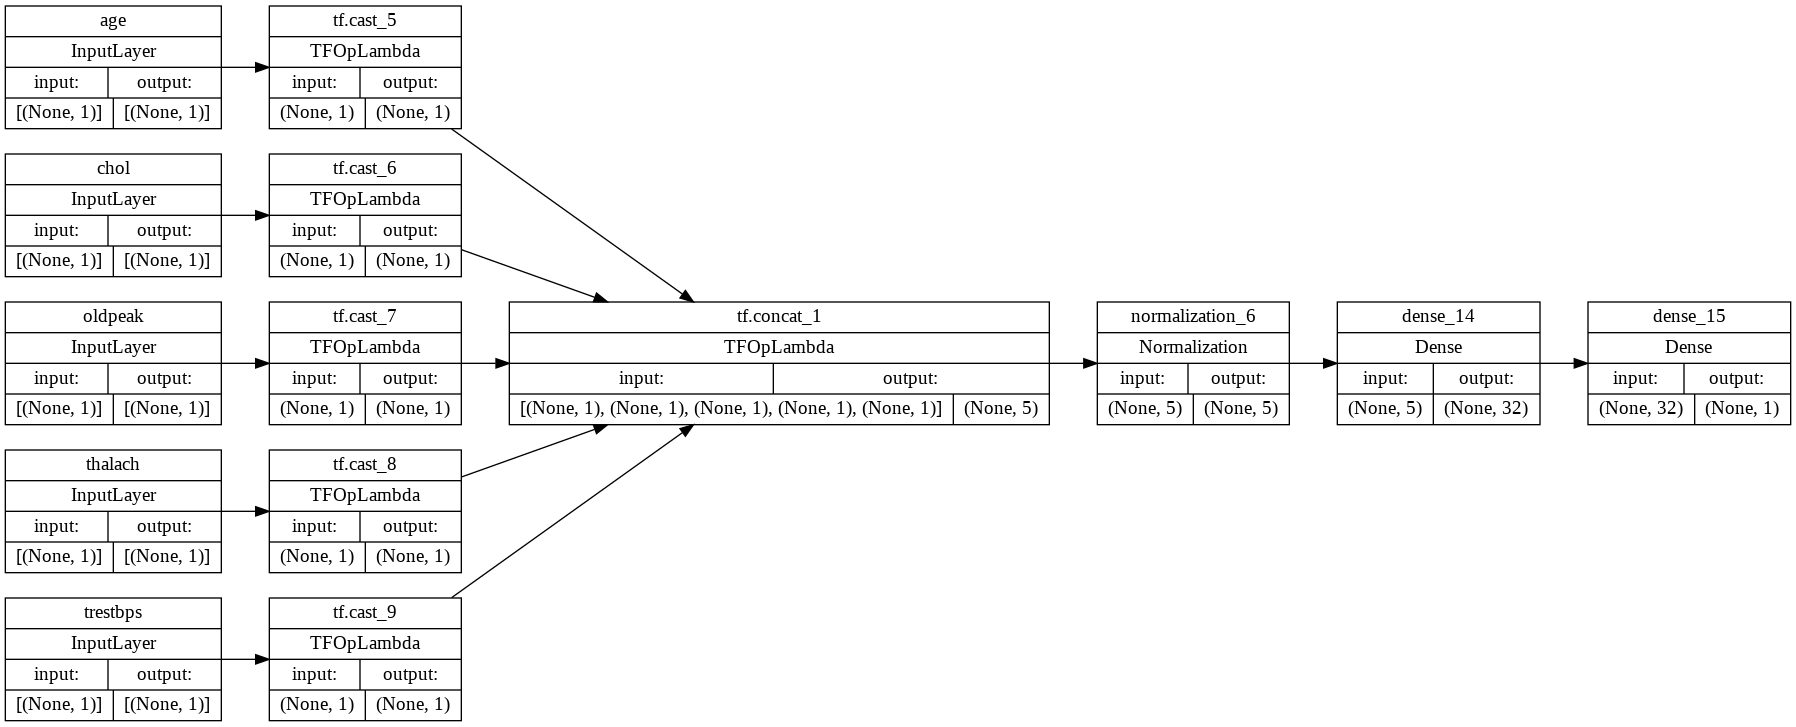

In [ ]:
tf.keras.utils.plot_model(my_base_model, show_shapes=True, rankdir='LR')

In [ ]:
my_base_model.fit(dict(features), y, epochs=5)

Epoch 1/5
10/10 [==============================] - 0s 2ms/step - loss: 0.7928 - accuracy: 0.5842
Epoch 2/5
10/10 [==============================] - 0s 2ms/step - loss: 0.7440 - accuracy: 0.6634
Epoch 3/5
10/10 [==============================] - 0s 2ms/step - loss: 0.7002 - accuracy: 0.7393
Epoch 4/5
10/10 [==============================] - 0s 2ms/step - loss: 0.6624 - accuracy: 0.7591
Epoch 5/5
10/10 [==============================] - 0s 2ms/step - loss: 0.6305 - accuracy: 0.7624


## End to End Example

If you're passing a heterogenous DataFrame to Keras, each column may need unique preprocessing. You could do this preprocessing directly in the DataFrame, but for a model to work correctly, inputs always need to be preprocessed the same way. So, the best approach is to build the preprocessing into the model.

**numeric_feature_names** = [ ' age ', ' thalach ', ' trestbps ',  ' chol ', ' oldpeak ' ]<br>
**binary_feature_names** = [ ' sex ', ' fbs ', ' exang ' ]<br>
**categorical_feature_names** = [ ' cp ', ' restecg ', ' slope ', ' thal ', ' ca ' ]<br>

### Functional API

In [ ]:
inputs = {}

for col in X.columns:

  if type(X[col][0]) == tf.int64:
    col_type = tf.int64
  elif type(X[col][0]) == str:
    col_type = tf.string
  else:
    col_type = tf.float64

  inputs[col] = tf.keras.Input(name=col, dtype=col_type, shape=(1,))
  
inputs 

{'age': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'age')>,
 'ca': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'ca')>,
 'chol': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'chol')>,
 'cp': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'cp')>,
 'exang': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'exang')>,
 'fbs': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'fbs')>,
 'oldpeak': <KerasTensor: shape=(None, 1) dtype=float64 (created by layer 'oldpeak')>,
 'restecg': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'restecg')>,
 'sex': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'sex')>,
 'slope': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'slope')>,
 'thal': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'thal')>,
 'thalach': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'thalach')>,
 'trestbps': <KerasTensor: shape=(None, 1

In [ ]:
# build a preprocessing model that will apply apropriate preprocessing to each to each input
preprocessed = []

# binary inputs don't need any preprocessing, just add them to preprocessed

for binary_input in binary_feature_names:
  inp = inputs[binary_input]
  preprocessed.append(tf.cast(inp, tf.float32))


# we'll want to run these numeric inputs through a tf.keras.layers.Normalization layer before using them. 

for numerical in numeric_feature_names:
  numerical_input = inputs[numerical]
  normalizer = tf.keras.layers.Normalization(axis=None)
  normalizer.adapt(X[numerical].values)
  normailzed = normalizer(numerical_input)
  preprocessed.append(normailzed)



#  To use categorical features you'll first need to encode them into either binary vectors or embeddings.
#  Since these features only contain a small number of categories,
#  convert the inputs directly to one-hot vectors using the output_mode='one_hot'


for cat in categorical_feature_names:
  cat_input = inputs[cat]
  cat_feature = X[cat]
  lookup = tf.keras.layers.StringLookup() if type(cat_feature[0])==str else tf.keras.layers.IntegerLookup()
  lookup.adapt(cat_feature)
  encoder = tf.keras.layers.CategoryEncoding(num_tokens=lookup.vocabulary_size(), output_mode='one_hot')
  vocab = lookup(cat_input)
  encoding = encoder(vocab)
  preprocessed.append(encoding)


preprocessed

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_231')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_232')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_233')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_92')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_93')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_94')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_95')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_96')>,
 <KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'category_encoding_155')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_156')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_157')>,
 <KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'c

In [ ]:
# Concatenate all the preprocessed features along the depth axis, 
# so each dictionary-example is converted into a single vector. 
preprocessed_concated = tf.keras.layers.concatenate(preprocessed, axis=-1)
preprocessed_concated

<KerasTensor: shape=(None, 33) dtype=float32 (created by layer 'concatenate_17')>

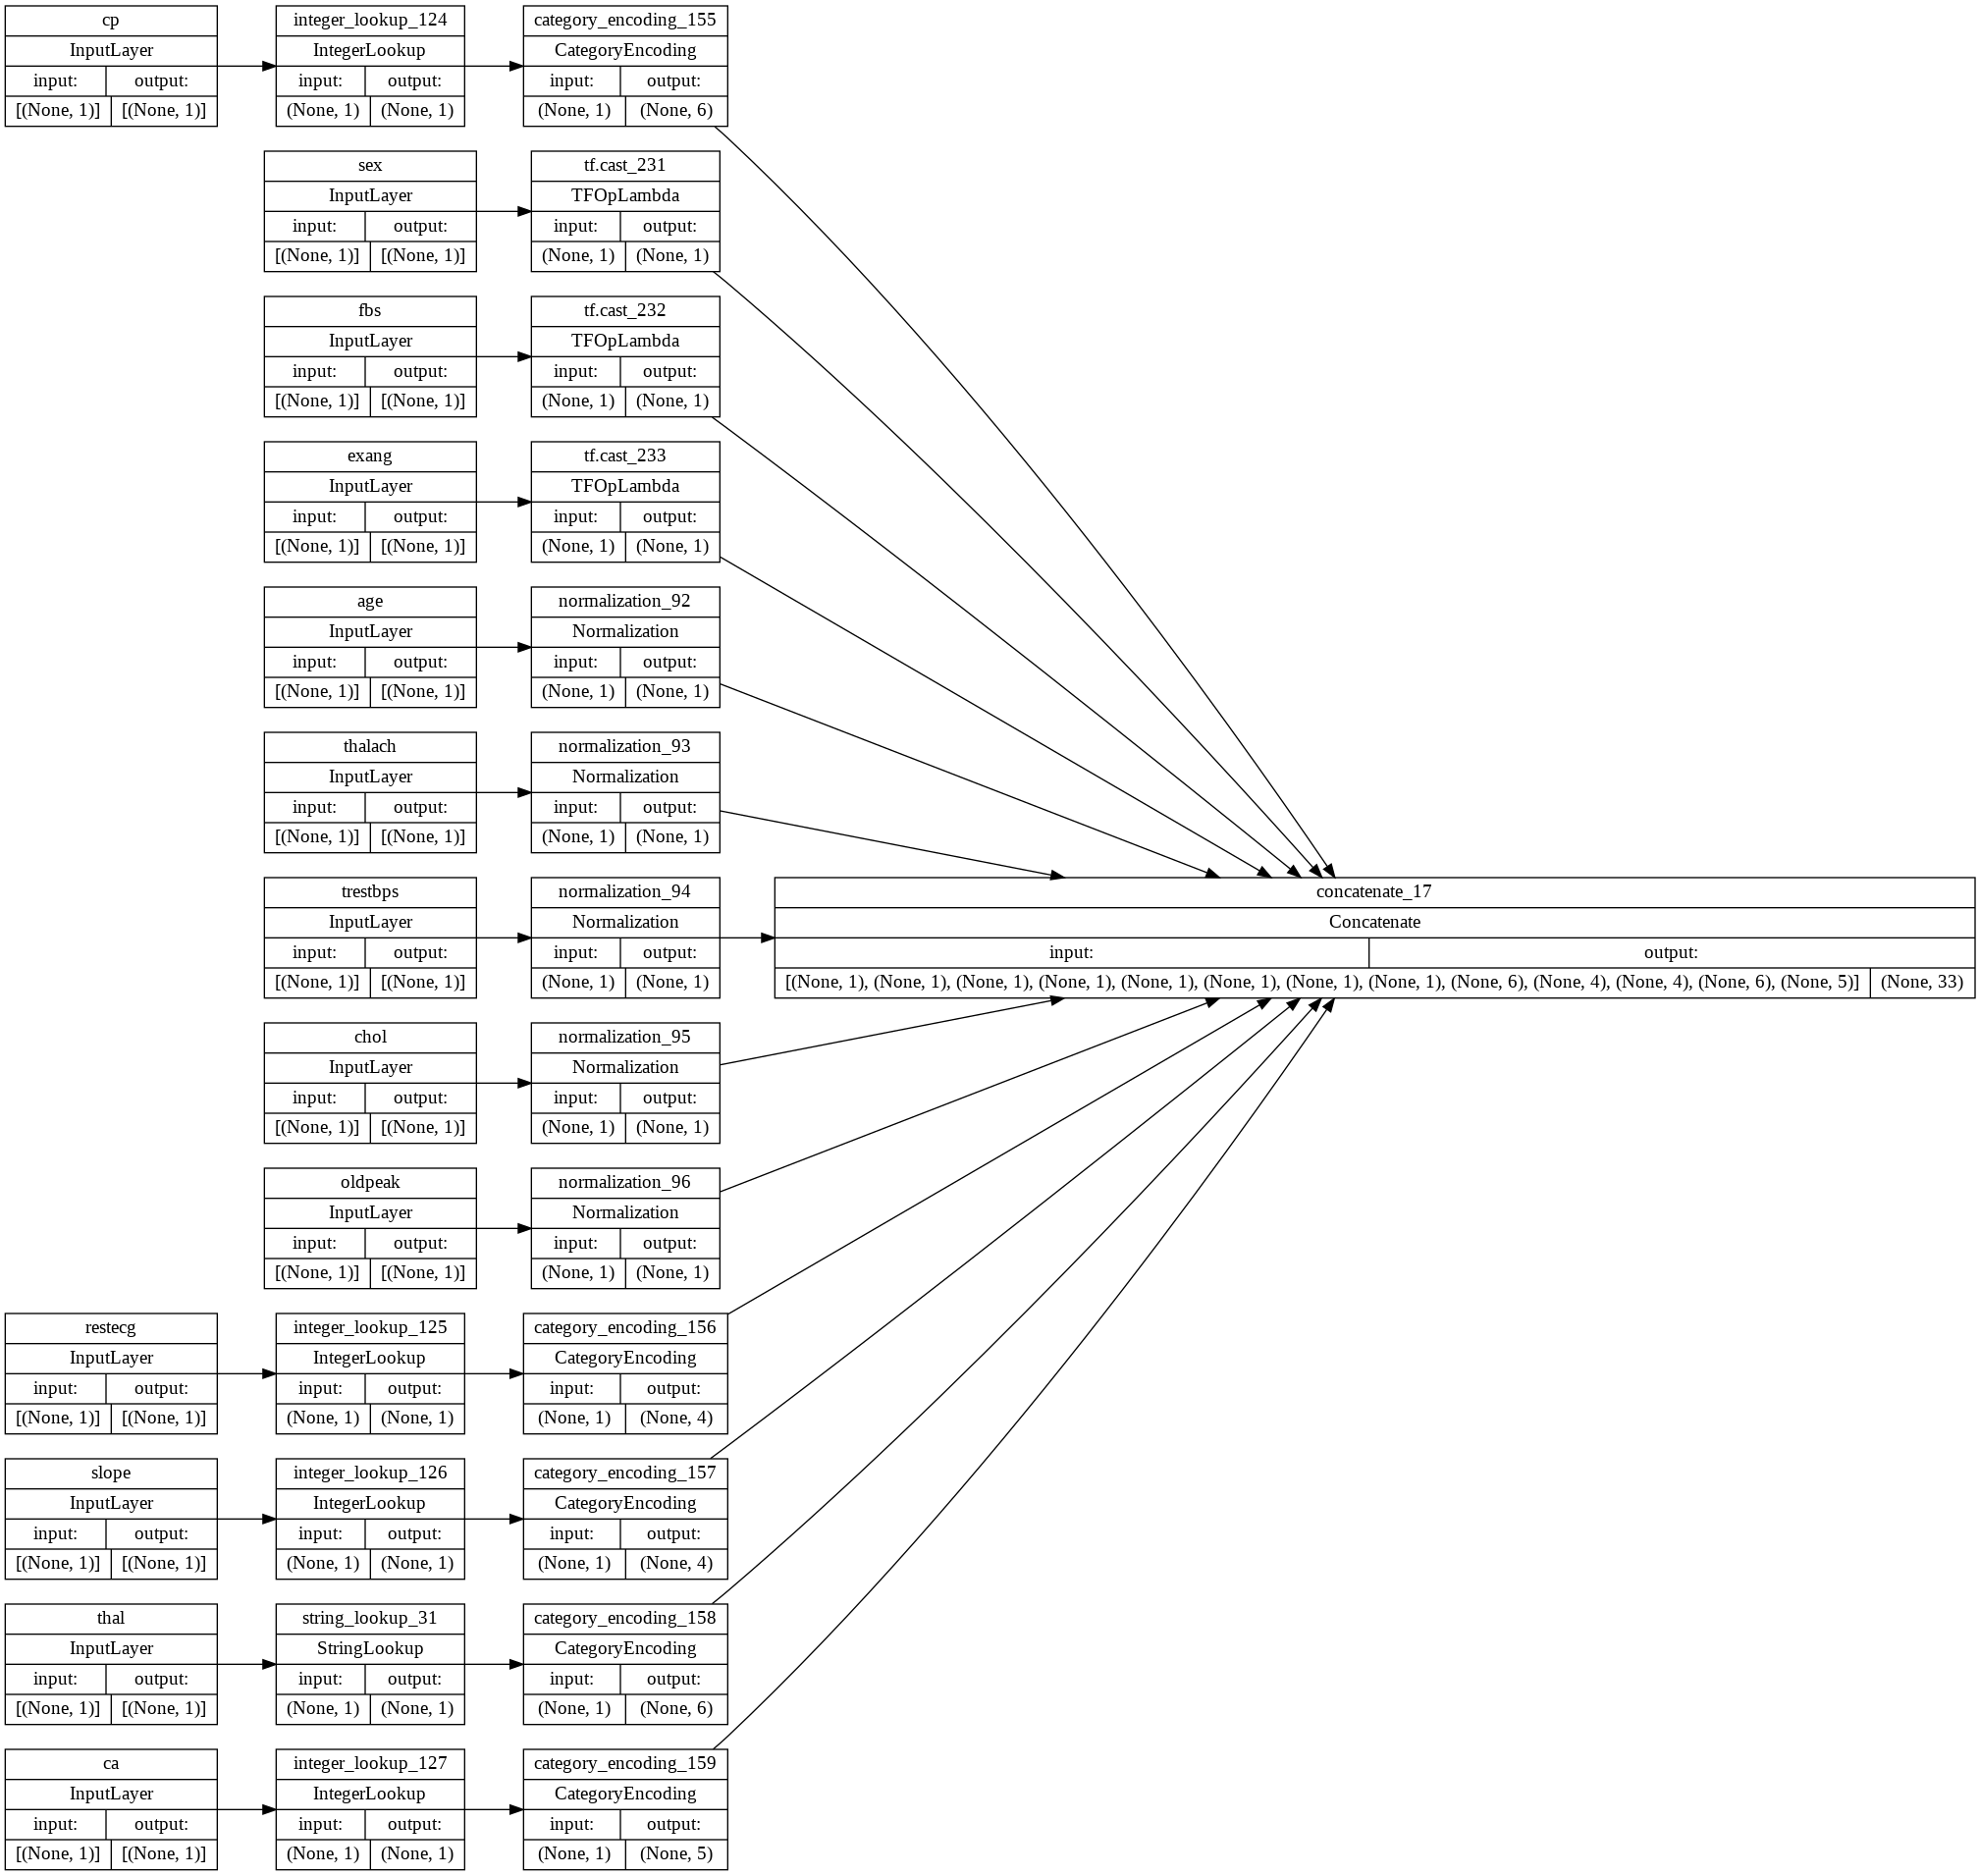

In [ ]:
# Now create a model out of that calculation so it can be reused:
preprocessor = tf.keras.Model(inputs, preprocessed_concated)

tf.keras.utils.plot_model(preprocessor, rankdir='LR', show_shapes=True)

In [ ]:
# preprocessing example
preprocessor(dict(X.iloc[1:2]))

<tf.Tensor: shape=(33,), dtype=float32, numpy=
array([ 1.        ,  0.        ,  1.        ,  1.3782105 , -1.7806165 ,
        1.5923285 ,  0.7573877 ,  0.38022864,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ], dtype=float32)>

In [ ]:
# lets build the body of the model
body = tf.keras.Sequential([
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(1)
])

In [ ]:
# Now put the two pieces together using the Keras functional API.
prep = preprocessor(inputs)
results = body(prep)
my_model = tf.keras.Model(inputs, results)

In [ ]:
# compiling
my_model.compile(optimizer='adam',
                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                 metrics=['accuracy'])
# training
my_model.fit(dict(X), y, epochs=5)

Epoch 1/5
10/10 [==============================] - 1s 3ms/step - loss: 0.7054 - accuracy: 0.6766
Epoch 2/5
10/10 [==============================] - 0s 3ms/step - loss: 0.5668 - accuracy: 0.7294
Epoch 3/5
10/10 [==============================] - 0s 2ms/step - loss: 0.4968 - accuracy: 0.7360
Epoch 4/5
10/10 [==============================] - 0s 2ms/step - loss: 0.4502 - accuracy: 0.7558
Epoch 5/5
10/10 [==============================] - 0s 2ms/step - loss: 0.4088 - accuracy: 0.7789


### Subclassing API


In [70]:
class SubclassModel(tf.keras.Model):
  def __init__(self,):
    super(SubclassModel,self).__init__()
    self.d1 = tf.keras.layers.Dense(32, 'relu')
    self.d2 = tf.keras.layers.Dense(16, 'relu')
    self.output_layer = tf.keras.layers.Dense(1)
    self.numeric_feature_names = ['age', 'thalach', 'trestbps',  'chol', 'oldpeak']
    self.binary_feature_names = ['sex', 'fbs', 'exang']
    self.integer_categorical_feature_names = ['cp', 'restecg', 'slope', 'ca']
    self.string_categorical_feature_names = ['thal',]
    

  def normalizer(self, feature_names, features):
    df = features.copy()
    df = df.loc[:,feature_names]
    normalizer = tf.keras.layers.Normalization()
    normalizer.adapt(df)
    self.normalizer = normalizer
    return normalizer(df)
  
  def categoryEncoding(self, feature_names, features, isString=False):
    df = features.copy()
    df = df.loc[:,feature_names]
    self.lookup = tf.keras.layers.StringLookup() if isString else tf.keras.layers.IntegerLookup()
    self.lookup.adapt(df)
    self.encoder = tf.keras.layers.CategoryEncoding(num_tokens=self.lookup.vocabulary_size())
    return self.encoder(self.lookup(df))
  
  def preprocessing(self, features):
    binary_features = tf.convert_to_tensor(tf.cast(X.loc[:,binary_feature_names], tf.float32))
    normalized = self.normalizer(self.numeric_feature_names, features)
    int_cat_encoded = self.categoryEncoding(self.integer_categorical_feature_names, features, isString=False)
    str_cat_encoded = self.categoryEncoding(self.string_categorical_feature_names, features, isString=True)
    preprocessed = [binary_features, normalized, int_cat_encoded, str_cat_encoded]
    return tf.keras.layers.concatenate(preprocessed)

  def call(self, x):
    x = self.d1(x)
    x = self.d2(x)
    x = self.output_layer(x)
    return x


In [71]:
# create and instance of the model
subclass_model = SubclassModel()
# compile the model
subclass_model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
# do feature preprocessing
features = subclass_model.preprocessing(X)
# train the model
subclass_model.fit(features, y, epochs=5)

Epoch 1/5
10/10 [==============================] - 0s 2ms/step - loss: 0.8690 - accuracy: 0.4521
Epoch 2/5
10/10 [==============================] - 0s 2ms/step - loss: 0.7609 - accuracy: 0.6568
Epoch 3/5
10/10 [==============================] - 0s 2ms/step - loss: 0.6819 - accuracy: 0.7558
Epoch 4/5
10/10 [==============================] - 0s 3ms/step - loss: 0.6219 - accuracy: 0.7657
Epoch 5/5
10/10 [==============================] - 0s 2ms/step - loss: 0.5734 - accuracy: 0.7690
